In [22]:
import numpy as np
from sklearn import datasets
from sklearn import preprocessing
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [23]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

In [24]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [25]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Files already downloaded and verified


In [28]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

In [29]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [31]:
batch_size=100
train_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory=True)

In [40]:
%%timeit -n1 -r1
VGG1_channels = [
    64, 64, 'Max', 128, 128, 'Max', 256, 256, 'Max'
]

import torch.nn as nn

class VGG(torch.nn.Module):
    def __init__(self, VGG_channels, in_channels=3):
        super().__init__()
        self.in_channels = in_channels
        self.layers = []
        self.convolution_layers = self.create_convolution_layers(VGG_channels)
        self.fcs = nn.Sequential(
                nn.Linear(4096, 10)
                )
        self.dropout = nn.Dropout(0.5)
        
        
    def forward(self, x):
        x = self.convolution_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fcs(x)
        return x

    def create_convolution_layers(self, VGG_channels):

        for channels in VGG_channels:
            if channels == 'Max':
                max_pool_layer = [nn.MaxPool2d(kernel_size=(2,2))]
                self.layers += max_pool_layer
            else:
                conv_layer = [nn.Conv2d(in_channels=self.in_channels, out_channels=channels,
                                                 kernel_size=(3,3), padding='same'), nn.ReLU()]
                self.layers += conv_layer
                self.in_channels = channels

        return nn.Sequential(*self.layers)   
    
model = VGG(VGG1_channels)
num_epochs = 5
cost = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    print('epoch: ', (epoch+1))
    correct, total = 0, 0
    running_loss = 0
    for images, labels in train_loader:
        y_hat = model(images)
        loss = cost(y_hat, labels)
        running_loss += loss.item()
        y_pred = torch.softmax(y_hat, dim=1)
        pred = y_pred.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += int(labels.shape[0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    epoch_loss = running_loss/total
    epoch_acc = correct/total
    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_acc)
    print(f'Epoch Loss: {epoch_loss}')
    print(f'Epoch Correct: {correct}')
    print(f'Epoch Accuracy: {epoch_acc}')
    
    val_correct, val_total = 0, 0
    running_val_loss = 0
    for val_inputs, val_labels in val_loader:
        val_outputs = model(val_inputs)
        val_loss = cost(val_outputs, val_labels)
        running_val_loss += val_loss.item()
        y_pred = torch.softmax(val_outputs, dim=1)
        pred = y_pred.max(1, keepdim=True)[1]
        val_correct += pred.eq(val_labels.view_as(pred)).sum().item()
        val_total += int(val_labels.shape[0])
    
    
    val_epoch_loss = running_val_loss/val_total
    val_epoch_acc = val_correct/val_total
    val_loss_history.append(val_epoch_loss)
    val_accuracy_history.append(val_epoch_acc)
    print(f'Epoch Validation Loss: {val_epoch_loss}')
    print(f'Epoch Validation Correct: {val_correct}')
    print(f'Epoch Validation Accuracy: {val_epoch_acc}')
    

epoch:  1
Epoch Loss: 0.02302159508228302
Epoch Correct: 5326
Epoch Accuracy: 0.10652
Epoch Validation Loss: 0.011507155752182007
Epoch Validation Correct: 565
Epoch Validation Accuracy: 0.113
epoch:  2
Epoch Loss: 0.02300003942012787
Epoch Correct: 5564
Epoch Accuracy: 0.11128
Epoch Validation Loss: 0.011484405088424682
Epoch Validation Correct: 646
Epoch Validation Accuracy: 0.1292
epoch:  3
Epoch Loss: 0.02273184412956238
Epoch Correct: 6716
Epoch Accuracy: 0.13432
Epoch Validation Loss: 0.011031094121932983
Epoch Validation Correct: 940
Epoch Validation Accuracy: 0.188
epoch:  4
Epoch Loss: 0.020668482184410097
Epoch Correct: 12404
Epoch Accuracy: 0.24808
Epoch Validation Loss: 0.010033513379096986
Epoch Validation Correct: 1335
Epoch Validation Accuracy: 0.267
epoch:  5
Epoch Loss: 0.019661246190071105
Epoch Correct: 14081
Epoch Accuracy: 0.28162
Epoch Validation Loss: 0.009609616112709045
Epoch Validation Correct: 1498
Epoch Validation Accuracy: 0.2996
25min 15s ± 0 ns per loop (

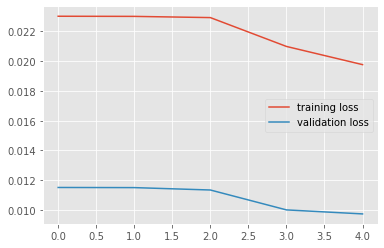

In [41]:
plt.style.use('ggplot')
plt.plot(train_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.legend()

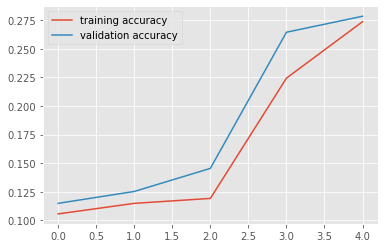

In [42]:
plt.style.use('ggplot')
plt.plot(train_accuracy_history, label='training accuracy')
plt.plot(val_accuracy_history, label='validation accuracy')
plt.legend()

In [44]:
test_correct, test_total = 0, 0
for test_inputs, test_labels in test_loader:
    test_outputs = model(test_inputs)
    y_pred = torch.softmax(test_outputs, dim=1)
    pred = y_pred.max(1, keepdim=True)[1]
    test_correct += pred.eq(test_labels.view_as(pred)).sum().item()
    test_total += int(test_labels.shape[0])

test_acc = test_correct/test_total
print(f'Test Accuracy: {test_acc}')

Test Accuracy: 0.2917


In [46]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

1186378

In [35]:
%%timeit -n1 -r1
VGG1_channels = [
    64, 64, 'Max', 128, 128, 'Max', 256, 256, 'Max'
]

import torch.nn as nn

class VGG(torch.nn.Module):
    def __init__(self, VGG_channels, in_channels=3):
        super().__init__()
        self.in_channels = in_channels
        self.layers = []
        self.convolution_layers = self.create_convolution_layers(VGG_channels)
        self.fcs = nn.Sequential(
                nn.Linear(4096, 10)
                )
        
        
    def forward(self, x):
        x = self.convolution_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

    def create_convolution_layers(self, VGG_channels):

        for channels in VGG_channels:
            if channels == 'Max':
                max_pool_layer = [nn.MaxPool2d(kernel_size=(2,2))]
                self.layers += max_pool_layer
            else:
                conv_layer = [nn.Conv2d(in_channels=self.in_channels, out_channels=channels,
                                                 kernel_size=(3,3), padding='same'), nn.ReLU(), nn.Dropout(0.5)]
                self.layers += conv_layer
                self.in_channels = channels

        return nn.Sequential(*self.layers)   
    
model = VGG(VGG1_channels)
num_epochs = 5
cost = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    print('epoch: ', (epoch+1))
    correct, total = 0, 0
    running_loss = 0
    for images, labels in train_loader:
        y_hat = model(images)
        loss = cost(y_hat, labels)
        running_loss += loss.item()
        y_pred = torch.softmax(y_hat, dim=1)
        pred = y_pred.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += int(labels.shape[0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    epoch_loss = running_loss/total
    epoch_acc = correct/total
    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_acc)
    print(f'Epoch Loss: {epoch_loss}')
    print(f'Epoch Correct: {correct}')
    print(f'Epoch Accuracy: {epoch_acc}')
    
    val_correct, val_total = 0, 0
    running_val_loss = 0
    for val_inputs, val_labels in val_loader:
        val_outputs = model(val_inputs)
        val_loss = cost(val_outputs, val_labels)
        running_val_loss += val_loss.item()
        y_pred = torch.softmax(val_outputs, dim=1)
        pred = y_pred.max(1, keepdim=True)[1]
        val_correct += pred.eq(val_labels.view_as(pred)).sum().item()
        val_total += int(val_labels.shape[0])
    
    
    val_epoch_loss = running_val_loss/val_total
    val_epoch_acc = val_correct/val_total
    val_loss_history.append(val_epoch_loss)
    val_accuracy_history.append(val_epoch_acc)
    print(f'Epoch Validation Loss: {val_epoch_loss}')
    print(f'Epoch Validation Correct: {val_correct}')
    print(f'Epoch Validation Accuracy: {val_epoch_acc}')
    

epoch:  1
Epoch Loss: 0.02212882021903992
Epoch Correct: 8259
Epoch Accuracy: 0.16518
Epoch Validation Loss: 0.01015260488986969
Epoch Validation Correct: 1326
Epoch Validation Accuracy: 0.2652
epoch:  2
Epoch Loss: 0.01960080114841461
Epoch Correct: 14640
Epoch Accuracy: 0.2928
Epoch Validation Loss: 0.009385487842559815
Epoch Validation Correct: 1667
Epoch Validation Accuracy: 0.3334
epoch:  3
Epoch Loss: 0.01809309182882309
Epoch Correct: 17632
Epoch Accuracy: 0.35264
Epoch Validation Loss: 0.008712910795211791
Epoch Validation Correct: 1903
Epoch Validation Accuracy: 0.3806
epoch:  4
Epoch Loss: 0.016913673858642578
Epoch Correct: 19651
Epoch Accuracy: 0.39302
Epoch Validation Loss: 0.008236195039749145
Epoch Validation Correct: 2038
Epoch Validation Accuracy: 0.4076
epoch:  5
Epoch Loss: 0.01600295642375946
Epoch Correct: 21160
Epoch Accuracy: 0.4232
Epoch Validation Loss: 0.00794416081905365
Epoch Validation Correct: 2153
Epoch Validation Accuracy: 0.4306
30min 10s ± 0 ns per loo

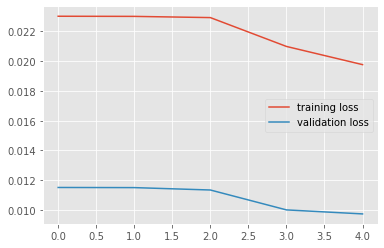

In [36]:
plt.style.use('ggplot')
plt.plot(train_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.legend()

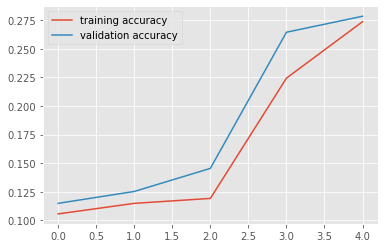

In [37]:
plt.style.use('ggplot')
plt.plot(train_accuracy_history, label='training accuracy')
plt.plot(val_accuracy_history, label='validation accuracy')
plt.legend()

In [39]:
test_correct, test_total = 0, 0
for test_inputs, test_labels in test_loader:
    test_outputs = model(test_inputs)
    y_pred = torch.softmax(test_outputs, dim=1)
    pred = y_pred.max(1, keepdim=True)[1]
    test_correct += pred.eq(test_labels.view_as(pred)).sum().item()
    test_total += int(test_labels.shape[0])

test_acc = test_correct/test_total
print(f'Test Accuracy: {test_acc}')

Test Accuracy: 0.2962


In [45]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

1186378